### **Загрузка необходимых библиотек и настройка путей**

In [42]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install  torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
! echo $PYTHONPATH

import os
os.environ['PYTHONPATH'] += "/content/drive/MyDrive/simplicialX"

! echo $PYTHONPATH

/env/python/content/drive/MyDrive/simplicialX
/env/python/content/drive/MyDrive/simplicialX/content/drive/MyDrive/simplicialX


In [44]:
import torch
from torch_geometric.datasets import TUDataset
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric
import networkx as nx
from drive.MyDrive.simplicialX.simplicialX.simplicialX.simplicial import SimplicialComplex
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

Загрузили датасет с белками

Теперь посмотрим на основные характеристики датасета

In [45]:
data = dataset[0]  # Get the first graph object.



print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1113
Number of features: 3
Number of edges: 162
Average node degree: 3.86
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### **Обогащение датасета**

In [ ]:
new_dataset_1 = []
new_dataset_2 = []
new_dataset_3 = []


for i in range(len(dataset)):
  print(i)
  graph = torch_geometric.utils.to_networkx(dataset[i])
  K = SimplicialComplex.from_graph(graph, kind='clique', n_skeleton=3)
  centrality_edge = K.simplex_betweenness_centrality(p=0, q=1, weighted=True, edge=False)
  centrality_triangle = K.simplex_betweenness_centrality(p=0, q=2, weighted=True, edge=False)
  new_features = torch.zeros(len(dataset[i].x), 2)
  for j in range(len(dataset[i].x)):
    if (j, ) in centrality_edge:
      new_features[j][0] = centrality_edge[(j, )]
  for j in range(len(dataset[i].x)):
    if (j, ) in centrality_triangle:
      new_features[j][1] = centrality_triangle[(j, )]
  new_features_3 = torch.cat([dataset[i].x, new_features], dim=1)
  new_features_2 = torch.cat([dataset[i].x, new_features[:, 1].reshape(-1, 1)], dim=1)
  new_features_1 = torch.cat([dataset[i].x, new_features[:, 0].reshape(-1, 1)], dim=1) 
  new_dataset_3.append(torch_geometric.data.Data(x=new_features_3, edge_index=dataset[i].edge_index, y=dataset[i].y))
  new_dataset_2.append(torch_geometric.data.Data(x=new_features_2, edge_index=dataset[i].edge_index, y=dataset[i].y))
  new_dataset_1.append(torch_geometric.data.Data(x=new_features_1, edge_index=dataset[i].edge_index, y=dataset[i].y))



In [ ]:
new_dataset_eigenvectors = []
for i in range(len(dataset)):
  print(i)
  # print(dataset[i])
  graph = torch_geometric.utils.to_networkx(dataset[i])
  K = SimplicialComplex.from_graph(graph, kind='clique', n_skeleton=3)
  L_mat = K.laplace_matrix(k=0, p=1, q=1)[:,:2 ]
  # print(L_mat.shape)
  new_features = torch.cat([dataset[i].x, torch.tensor(L_mat)], dim=1)
  new_dataset_eigenvectors.append(torch_geometric.data.Data(x=new_features.float(), edge_index=dataset[i].edge_index, y=dataset[i].y))


### **Перемешивание и разделение данных**

In [48]:
torch.manual_seed(42)
np.random.shuffle(new_dataset_eigenvectors)
np.random.shuffle(new_dataset_1)
np.random.shuffle(new_dataset_2)
np.random.shuffle(new_dataset_3)

dataset = dataset.shuffle()
train_dataset = dataset[150:-150]
test_dataset = dataset[0:150]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 813
Number of test graphs: 150


In [49]:
from torch_geometric.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### **Создание классов необходимых моделей**

In [50]:

class myGCNClassy(torch.nn.Module):
    def __init__(self, hidden_channels, num_channels, in_channels, out=dataset.num_classes):
      super(myGCNClassy, self).__init__()
      self.gcn = torch_geometric.nn.models.GCN(in_channels=in_channels,
                                               hidden_channels=hidden_channels,
                                               num_layers=num_channels,
                                               out_channels=hidden_channels)
      self.lin = torch_geometric.nn.Linear(hidden_channels, out)
    
    def forward(self, x, edge_index, batch):
      x = self.gcn(x, edge_index)
      x = x.relu()
      x = torch_geometric.nn.pool.global_mean_pool(x, batch)  # [batch_size, hidden_channels]
      x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
      x = self.lin(x)
      return x


class myGATClassy(torch.nn.Module):
    def __init__(self, hidden_channels, num_channels, in_channels):
      super(myGATClassy, self).__init__()
      self.gcn = torch_geometric.nn.models.GAT(in_channels=in_channels,
                                               hidden_channels=hidden_channels,
                                               num_layers=num_channels,
                                               out_channels=hidden_channels)
      self.lin = torch_geometric.nn.Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index, batch):
      x = self.gcn(x, edge_index)
      x = x.relu()
      x = torch_geometric.nn.pool.global_mean_pool(x, batch)  # [batch_size, hidden_channels]

      x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
      x = self.lin(x)
      return x


    
# model = myGCN(hidden_channels=64)
classy_gcn = myGCNClassy(hidden_channels=64, num_channels=6, in_channels=3)
classy_gat = myGATClassy(hidden_channels=64, num_channels=4, in_channels=3)
# print(model)
print(classy_gcn)
print(classy_gat)

myGCNClassy(
  (gcn): GCN(3, 64, num_layers=6)
  (lin): Linear(64, 2, bias=True)
)
myGATClassy(
  (gcn): GAT(3, 64, num_layers=4)
  (lin): Linear(64, 2, bias=True)
)


### **Процесс обучения на непредподготовленных данных**

In [51]:
optimizer = torch.optim.Adam(classy_gcn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
loss_coord, loss_vals = [], []


def train():
    classy_gcn.train()

    for data in train_loader:  
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      loss = criterion(out, data.y)  
      loss_vals.append(loss.item())
      loss.backward() 
      optimizer.step() 
      optimizer.zero_grad()  
      
def test(loader):
  classy_gcn.eval()

  correct = 0
  for data in loader: 
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset) 

test_accuracies = []
for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5904, Test Acc: 0.5933
Epoch: 002, Train Acc: 0.5904, Test Acc: 0.5933
Epoch: 003, Train Acc: 0.5904, Test Acc: 0.5933
Epoch: 004, Train Acc: 0.6039, Test Acc: 0.6133
Epoch: 005, Train Acc: 0.6199, Test Acc: 0.6133
Epoch: 006, Train Acc: 0.7048, Test Acc: 0.6600
Epoch: 007, Train Acc: 0.6962, Test Acc: 0.6867
Epoch: 008, Train Acc: 0.6950, Test Acc: 0.7067
Epoch: 009, Train Acc: 0.7048, Test Acc: 0.7000
Epoch: 010, Train Acc: 0.7073, Test Acc: 0.6867
Epoch: 011, Train Acc: 0.6777, Test Acc: 0.6667
Epoch: 012, Train Acc: 0.7159, Test Acc: 0.6667
Epoch: 013, Train Acc: 0.7048, Test Acc: 0.6533
Epoch: 014, Train Acc: 0.6827, Test Acc: 0.6800
Epoch: 015, Train Acc: 0.7060, Test Acc: 0.6933
Epoch: 016, Train Acc: 0.7122, Test Acc: 0.6933
Epoch: 017, Train Acc: 0.7109, Test Acc: 0.7000
Epoch: 018, Train Acc: 0.6802, Test Acc: 0.6733
Epoch: 019, Train Acc: 0.7060, Test Acc: 0.7000
Epoch: 020, Train Acc: 0.7036, Test Acc: 0.6533
Epoch: 021, Train Acc: 0.6654, Test Acc:

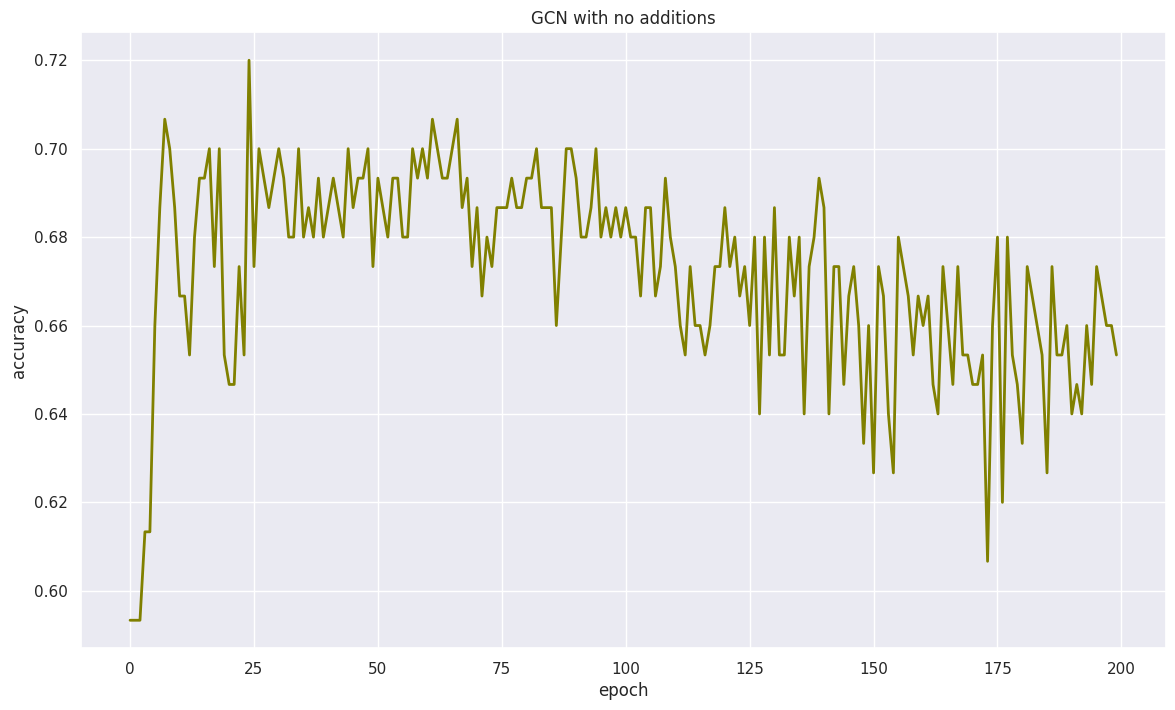

In [52]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies, color='olive',
     linewidth=2, label='accuracy')
plt.title('GCN with no additions')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [53]:
model = myGATClassy(hidden_channels=64, num_channels=4, in_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  
      out = model(data.x, data.edge_index, data.batch) 
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()  
      

def test(loader):
  model.eval()

  correct = 0
  for data in loader:  
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1) 
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset)  

test_accuracies_gat = []

for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_gat.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5904, Test Acc: 0.5933
Epoch: 002, Train Acc: 0.6039, Test Acc: 0.6133
Epoch: 003, Train Acc: 0.6802, Test Acc: 0.6267
Epoch: 004, Train Acc: 0.6962, Test Acc: 0.6600
Epoch: 005, Train Acc: 0.6408, Test Acc: 0.6600
Epoch: 006, Train Acc: 0.6913, Test Acc: 0.6267
Epoch: 007, Train Acc: 0.6827, Test Acc: 0.6400
Epoch: 008, Train Acc: 0.7073, Test Acc: 0.7000
Epoch: 009, Train Acc: 0.6937, Test Acc: 0.6600
Epoch: 010, Train Acc: 0.7048, Test Acc: 0.6667
Epoch: 011, Train Acc: 0.7097, Test Acc: 0.6667
Epoch: 012, Train Acc: 0.7208, Test Acc: 0.6800
Epoch: 013, Train Acc: 0.7208, Test Acc: 0.6733
Epoch: 014, Train Acc: 0.7257, Test Acc: 0.6667
Epoch: 015, Train Acc: 0.6888, Test Acc: 0.6667
Epoch: 016, Train Acc: 0.6913, Test Acc: 0.6533
Epoch: 017, Train Acc: 0.6974, Test Acc: 0.6467
Epoch: 018, Train Acc: 0.7171, Test Acc: 0.6667
Epoch: 019, Train Acc: 0.7257, Test Acc: 0.6733
Epoch: 020, Train Acc: 0.7036, Test Acc: 0.6733
Epoch: 021, Train Acc: 0.7134, Test Acc:

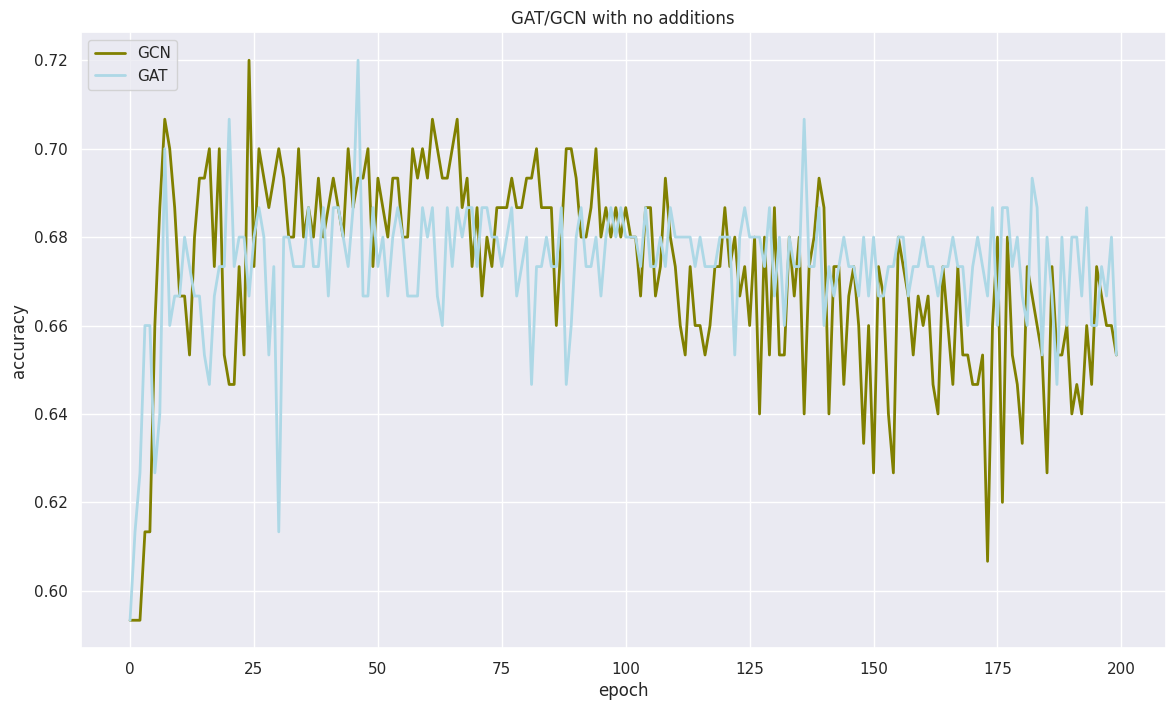

In [54]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies, color='olive',
     linewidth=2, label='GCN')
plt.plot(test_accuracies_gat, color='lightblue',
     linewidth=2, label='GAT')
plt.legend(loc='upper left')
plt.title('GAT/GCN with no additions')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [55]:
print(max(test_accuracies), max(test_accuracies_gat))

0.72 0.72


### **Загрузка данных с обеими центральностями. Обучение.**

In [56]:
train_dataset_3 = new_dataset_3[150:-150]
test_dataset_3 = new_dataset_3[0:150]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
train_loader = DataLoader(train_dataset_3, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_3, batch_size=64, shuffle=False)

Number of training graphs: 813
Number of test graphs: 150


In [57]:
classy_gcn = myGCNClassy(hidden_channels=64, num_channels=6, in_channels=5)
optimizer = torch.optim.Adam(classy_gcn.parameters(), lr=0.001)
# Define our loss function
criterion = torch.nn.CrossEntropyLoss()
loss_coord, loss_vals = [], []


def train():
    classy_gcn.train()

    for data in train_loader:  
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      loss = criterion(out, data.y)  
      loss_vals.append(loss.item())
      loss.backward() 
      optimizer.step() 
      optimizer.zero_grad()  
      
def test(loader):
  classy_gcn.eval()

  correct = 0
  for data in loader: 
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset) 

test_accuracies_3_gcn = []
for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_3_gcn.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6027, Test Acc: 0.6133
Epoch: 002, Train Acc: 0.6027, Test Acc: 0.6133
Epoch: 003, Train Acc: 0.6015, Test Acc: 0.6133
Epoch: 004, Train Acc: 0.6814, Test Acc: 0.6867
Epoch: 005, Train Acc: 0.7146, Test Acc: 0.7133
Epoch: 006, Train Acc: 0.7171, Test Acc: 0.7000
Epoch: 007, Train Acc: 0.7134, Test Acc: 0.7133
Epoch: 008, Train Acc: 0.7109, Test Acc: 0.7133
Epoch: 009, Train Acc: 0.6999, Test Acc: 0.6933
Epoch: 010, Train Acc: 0.7392, Test Acc: 0.7200
Epoch: 011, Train Acc: 0.7183, Test Acc: 0.7000
Epoch: 012, Train Acc: 0.7392, Test Acc: 0.7133
Epoch: 013, Train Acc: 0.7245, Test Acc: 0.7000
Epoch: 014, Train Acc: 0.7491, Test Acc: 0.7133
Epoch: 015, Train Acc: 0.7405, Test Acc: 0.7067
Epoch: 016, Train Acc: 0.7442, Test Acc: 0.7400
Epoch: 017, Train Acc: 0.7331, Test Acc: 0.7067
Epoch: 018, Train Acc: 0.7417, Test Acc: 0.7267
Epoch: 019, Train Acc: 0.7319, Test Acc: 0.7067
Epoch: 020, Train Acc: 0.7491, Test Acc: 0.7333
Epoch: 021, Train Acc: 0.7392, Test Acc:

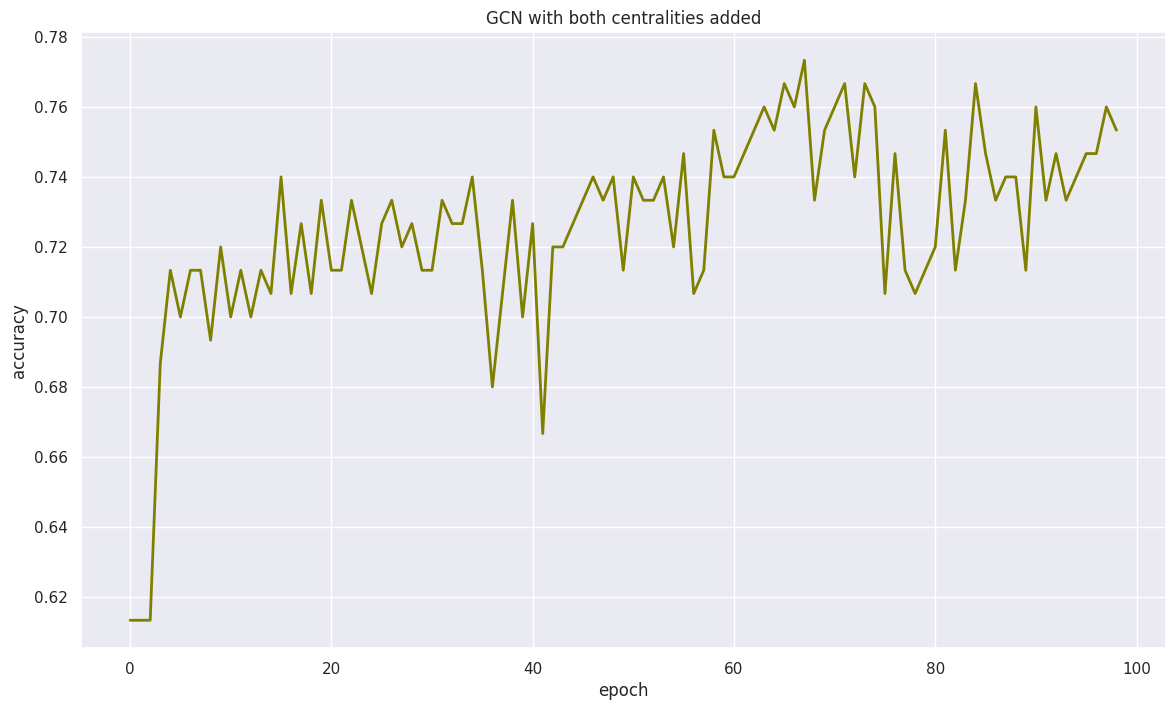

In [58]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies_3_gcn, color='olive',
     linewidth=2, label='accuracy')
plt.title('GCN with both centralities added')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [59]:
model = myGATClassy(hidden_channels=64, num_channels=4, in_channels=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  
      out = model(data.x, data.edge_index, data.batch) 
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()  
      

def test(loader):
  model.eval()

  correct = 0
  for data in loader:  
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1) 
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset)  

test_accuracies_3_gat = []

for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_3_gat.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6027, Test Acc: 0.6133
Epoch: 002, Train Acc: 0.6248, Test Acc: 0.6267
Epoch: 003, Train Acc: 0.7073, Test Acc: 0.6667
Epoch: 004, Train Acc: 0.7159, Test Acc: 0.7000
Epoch: 005, Train Acc: 0.7282, Test Acc: 0.6800
Epoch: 006, Train Acc: 0.7048, Test Acc: 0.7000
Epoch: 007, Train Acc: 0.7183, Test Acc: 0.6867
Epoch: 008, Train Acc: 0.7306, Test Acc: 0.7200
Epoch: 009, Train Acc: 0.7429, Test Acc: 0.7133
Epoch: 010, Train Acc: 0.7220, Test Acc: 0.7200
Epoch: 011, Train Acc: 0.7257, Test Acc: 0.7133
Epoch: 012, Train Acc: 0.7442, Test Acc: 0.7133
Epoch: 013, Train Acc: 0.7442, Test Acc: 0.7133
Epoch: 014, Train Acc: 0.7257, Test Acc: 0.7200
Epoch: 015, Train Acc: 0.7343, Test Acc: 0.7133
Epoch: 016, Train Acc: 0.7417, Test Acc: 0.7067
Epoch: 017, Train Acc: 0.7380, Test Acc: 0.7067
Epoch: 018, Train Acc: 0.6568, Test Acc: 0.6333
Epoch: 019, Train Acc: 0.7368, Test Acc: 0.6867
Epoch: 020, Train Acc: 0.7257, Test Acc: 0.6800
Epoch: 021, Train Acc: 0.7232, Test Acc:

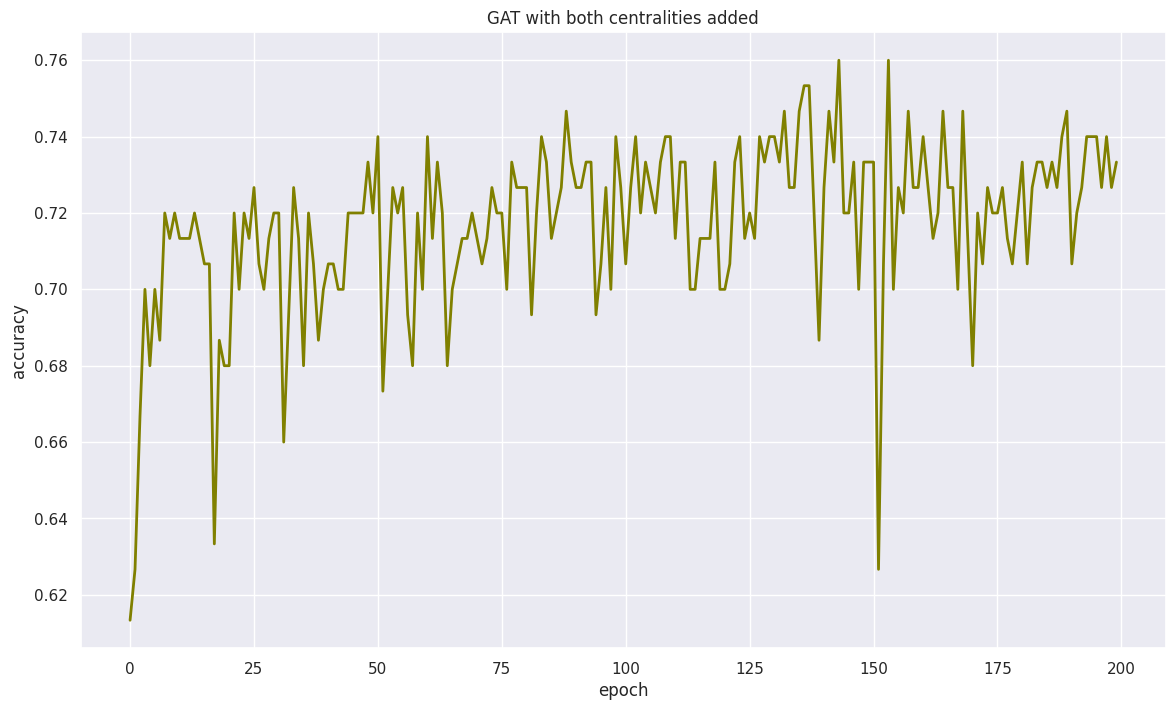

In [60]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies_3_gat, color='olive',
     linewidth=2, label='accuracy')
plt.title('GAT with both centralities added')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### **Загрузка новых данных с реберной центральностью. Обучение.**

In [61]:
train_dataset_2_1 = new_dataset_2[150:-150]
test_dataset_2_1 = new_dataset_2[0:150]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
train_loader = DataLoader(train_dataset_2_1, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_2_1, batch_size=64, shuffle=False)

Number of training graphs: 813
Number of test graphs: 150


In [62]:
classy_gcn = myGCNClassy(hidden_channels=64, num_channels=6, in_channels=4)
optimizer = torch.optim.Adam(classy_gcn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
loss_coord, loss_vals = [], []


def train():
    classy_gcn.train()

    for data in train_loader:  
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      loss = criterion(out, data.y)  
      loss_vals.append(loss.item())
      loss.backward() 
      optimizer.step() 
      optimizer.zero_grad()  
      
def test(loader):
  classy_gcn.eval()

  correct = 0
  for data in loader: 
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset) 

test_accuracies_2_gcn = []
for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_2_gcn.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5867, Test Acc: 0.5733
Epoch: 002, Train Acc: 0.5867, Test Acc: 0.5733
Epoch: 003, Train Acc: 0.5867, Test Acc: 0.5733
Epoch: 004, Train Acc: 0.5867, Test Acc: 0.5733
Epoch: 005, Train Acc: 0.6790, Test Acc: 0.6667
Epoch: 006, Train Acc: 0.6777, Test Acc: 0.6800
Epoch: 007, Train Acc: 0.6986, Test Acc: 0.7200
Epoch: 008, Train Acc: 0.7183, Test Acc: 0.7333
Epoch: 009, Train Acc: 0.7023, Test Acc: 0.7067
Epoch: 010, Train Acc: 0.7257, Test Acc: 0.7333
Epoch: 011, Train Acc: 0.7060, Test Acc: 0.7133
Epoch: 012, Train Acc: 0.7196, Test Acc: 0.7200
Epoch: 013, Train Acc: 0.7269, Test Acc: 0.7200
Epoch: 014, Train Acc: 0.7036, Test Acc: 0.7067
Epoch: 015, Train Acc: 0.7183, Test Acc: 0.7333
Epoch: 016, Train Acc: 0.7245, Test Acc: 0.7133
Epoch: 017, Train Acc: 0.6876, Test Acc: 0.7000
Epoch: 018, Train Acc: 0.7134, Test Acc: 0.7333
Epoch: 019, Train Acc: 0.7196, Test Acc: 0.7133
Epoch: 020, Train Acc: 0.7257, Test Acc: 0.7267
Epoch: 021, Train Acc: 0.7257, Test Acc:

In [63]:
model = myGATClassy(hidden_channels=64, num_channels=4, in_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  
      out = model(data.x, data.edge_index, data.batch) 
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()  
      

def test(loader):
  model.eval()

  correct = 0
  for data in loader:  
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1) 
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset)  

test_accuracies_2_gat = []

for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_2_gat.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5867, Test Acc: 0.5733
Epoch: 002, Train Acc: 0.6999, Test Acc: 0.7000
Epoch: 003, Train Acc: 0.6261, Test Acc: 0.6067
Epoch: 004, Train Acc: 0.6900, Test Acc: 0.6667
Epoch: 005, Train Acc: 0.7073, Test Acc: 0.6867
Epoch: 006, Train Acc: 0.6925, Test Acc: 0.6400
Epoch: 007, Train Acc: 0.6999, Test Acc: 0.6800
Epoch: 008, Train Acc: 0.7023, Test Acc: 0.6933
Epoch: 009, Train Acc: 0.7380, Test Acc: 0.7133
Epoch: 010, Train Acc: 0.7380, Test Acc: 0.6933
Epoch: 011, Train Acc: 0.6937, Test Acc: 0.6800
Epoch: 012, Train Acc: 0.7269, Test Acc: 0.6800
Epoch: 013, Train Acc: 0.7343, Test Acc: 0.6933
Epoch: 014, Train Acc: 0.7171, Test Acc: 0.7067
Epoch: 015, Train Acc: 0.7343, Test Acc: 0.7133
Epoch: 016, Train Acc: 0.7343, Test Acc: 0.7267
Epoch: 017, Train Acc: 0.7122, Test Acc: 0.6667
Epoch: 018, Train Acc: 0.7405, Test Acc: 0.7267
Epoch: 019, Train Acc: 0.7503, Test Acc: 0.7267
Epoch: 020, Train Acc: 0.7417, Test Acc: 0.7200
Epoch: 021, Train Acc: 0.7319, Test Acc:

In [64]:
print(max(test_accuracies_2_gcn), max(test_accuracies_2_gat))

0.7533333333333333 0.7533333333333333


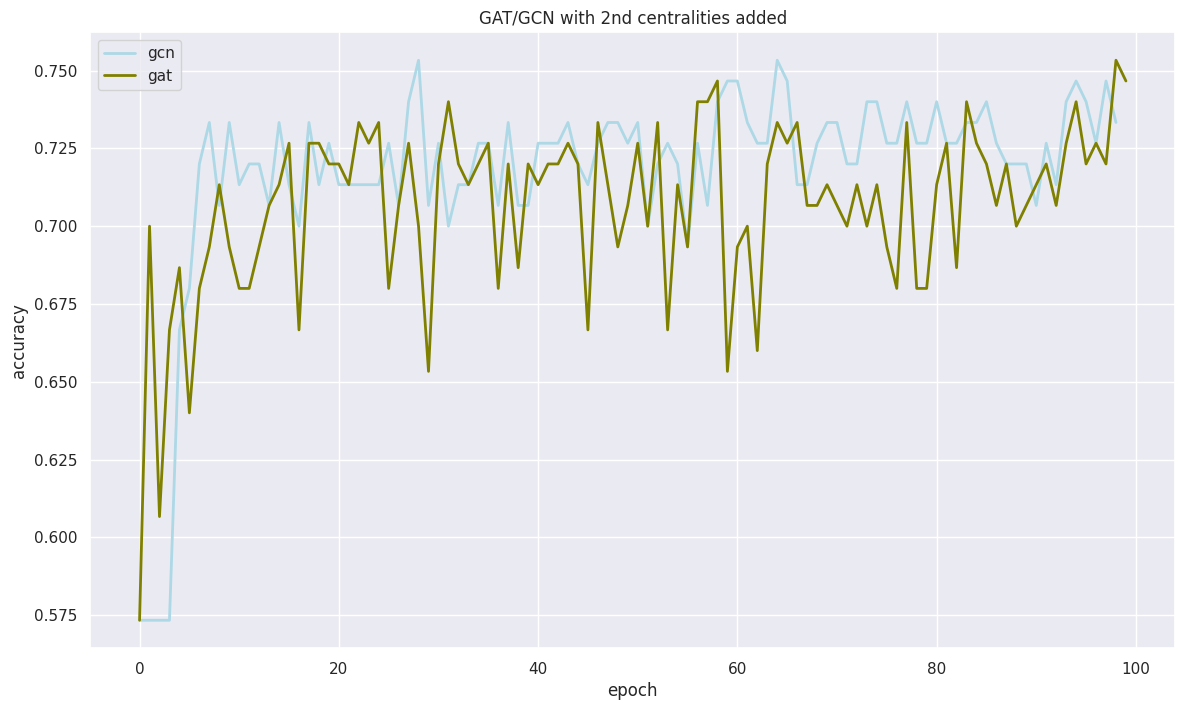

In [65]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies_2_gcn, color='lightblue',
     linewidth=2, label='gcn')
plt.plot(test_accuracies_2_gat, color='olive',
     linewidth=2, label='gat')
plt.legend(loc='upper left')
plt.title('GAT/GCN with 2nd centralities added')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### **Загрузка данных с первой центральностью и обучение**

In [66]:
train_dataset_2_1 = new_dataset_1[150:-150]
test_dataset_2_1 = new_dataset_1[0:150]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
train_loader = DataLoader(train_dataset_2_1, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_2_1, batch_size=64, shuffle=False)

Number of training graphs: 813
Number of test graphs: 150


In [67]:
classy_gcn = myGCNClassy(hidden_channels=64, num_channels=6, in_channels=4)
optimizer = torch.optim.Adam(classy_gcn.parameters(), lr=0.001)
# Define our loss function
criterion = torch.nn.CrossEntropyLoss()
loss_coord, loss_vals = [], []


def train():
    classy_gcn.train()

    for data in train_loader:  
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      loss = criterion(out, data.y)  
      loss_vals.append(loss.item())
      loss.backward() 
      optimizer.step() 
      optimizer.zero_grad()  
      
def test(loader):
  classy_gcn.eval()

  correct = 0
  for data in loader: 
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset) 

test_accuracies_1_gcn = []
for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_1_gcn.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5941, Test Acc: 0.5867
Epoch: 002, Train Acc: 0.5941, Test Acc: 0.5867
Epoch: 003, Train Acc: 0.6138, Test Acc: 0.5933
Epoch: 004, Train Acc: 0.6359, Test Acc: 0.5733
Epoch: 005, Train Acc: 0.6458, Test Acc: 0.5800
Epoch: 006, Train Acc: 0.6654, Test Acc: 0.6000
Epoch: 007, Train Acc: 0.6740, Test Acc: 0.5933
Epoch: 008, Train Acc: 0.6777, Test Acc: 0.6867
Epoch: 009, Train Acc: 0.7073, Test Acc: 0.7067
Epoch: 010, Train Acc: 0.6691, Test Acc: 0.6733
Epoch: 011, Train Acc: 0.7122, Test Acc: 0.7267
Epoch: 012, Train Acc: 0.7085, Test Acc: 0.7200
Epoch: 013, Train Acc: 0.6999, Test Acc: 0.7200
Epoch: 014, Train Acc: 0.7073, Test Acc: 0.7333
Epoch: 015, Train Acc: 0.7146, Test Acc: 0.7267
Epoch: 016, Train Acc: 0.6876, Test Acc: 0.6733
Epoch: 017, Train Acc: 0.7196, Test Acc: 0.7200
Epoch: 018, Train Acc: 0.7023, Test Acc: 0.7333
Epoch: 019, Train Acc: 0.7097, Test Acc: 0.7267
Epoch: 020, Train Acc: 0.7171, Test Acc: 0.7067
Epoch: 021, Train Acc: 0.6950, Test Acc:

In [68]:
model = myGATClassy(hidden_channels=64, num_channels=4, in_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  
      out = model(data.x, data.edge_index, data.batch) 
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()  
      

def test(loader):
  model.eval()

  correct = 0
  for data in loader:  
      out = model(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1) 
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset)  

test_accuracies_1_gat = []

for epoch in range(1, 101):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_1_gat.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6298, Test Acc: 0.5800
Epoch: 002, Train Acc: 0.6728, Test Acc: 0.6067
Epoch: 003, Train Acc: 0.6445, Test Acc: 0.5667
Epoch: 004, Train Acc: 0.6777, Test Acc: 0.5933
Epoch: 005, Train Acc: 0.6728, Test Acc: 0.5933
Epoch: 006, Train Acc: 0.6777, Test Acc: 0.5933
Epoch: 007, Train Acc: 0.6937, Test Acc: 0.6467
Epoch: 008, Train Acc: 0.6753, Test Acc: 0.5867
Epoch: 009, Train Acc: 0.7159, Test Acc: 0.6933
Epoch: 010, Train Acc: 0.7171, Test Acc: 0.7000
Epoch: 011, Train Acc: 0.7023, Test Acc: 0.7067
Epoch: 012, Train Acc: 0.6925, Test Acc: 0.6667
Epoch: 013, Train Acc: 0.7122, Test Acc: 0.6867
Epoch: 014, Train Acc: 0.7011, Test Acc: 0.6800
Epoch: 015, Train Acc: 0.7232, Test Acc: 0.7000
Epoch: 016, Train Acc: 0.7220, Test Acc: 0.7000
Epoch: 017, Train Acc: 0.7269, Test Acc: 0.7067
Epoch: 018, Train Acc: 0.7097, Test Acc: 0.7267
Epoch: 019, Train Acc: 0.7245, Test Acc: 0.7000
Epoch: 020, Train Acc: 0.7257, Test Acc: 0.6733
Epoch: 021, Train Acc: 0.7048, Test Acc:

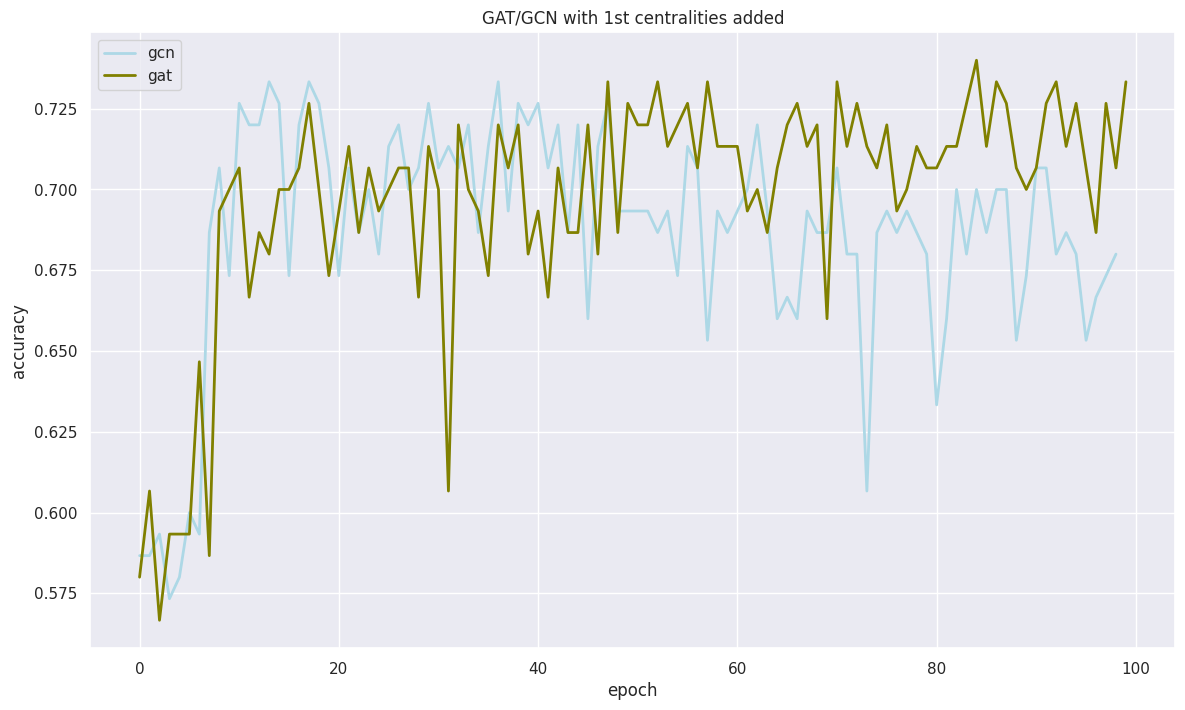

In [69]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies_1_gcn, color='lightblue',
     linewidth=2, label='gcn')
plt.plot(test_accuracies_1_gat, color='olive',
     linewidth=2, label='gat')
plt.legend(loc='upper left')
plt.title('GAT/GCN with 1st centralities added')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### **Использование датасета ENZYEMES**

In [70]:
enz_set = TUDataset(root='data/TUDataset', name='ENZYMES')

In [ ]:
new_enz_1 = []


for i in range(len(enz_set)):
  print(i)
  graph = torch_geometric.utils.to_networkx(enz_set[i])
  K = SimplicialComplex.from_graph(graph, kind='clique', n_skeleton=3)
  centrality_edge = K.simplex_betweenness_centrality(p=0, q=1, weighted=True, edge=False)
  L_mat = K.laplace_matrix(k=0, p=1, q=1)[:,:2 ]
  new_features = torch.zeros(len(enz_set[i].x), 2)
  for j in range(len(enz_set[i].x)):
    if (j, ) in centrality_edge:
      new_features[j][0] = centrality_edge[(j, )]
  new_features_1 = torch.cat([enz_set[i].x, new_features[:, 0].reshape(-1, 1)], dim=1) 
  new_features_1 = torch.cat([new_features_1, torch.tensor(L_mat)], dim=1) 
  new_enz_1.append(torch_geometric.data.Data(x=new_features_1.float(), edge_index=enz_set[i].edge_index, y=enz_set[i].y))

In [ ]:
enzymes_eigenvectors = []
for i in range(len(enz_set)):
  print(i)
  print(enz_set[i])
  graph = torch_geometric.utils.to_networkx(enz_set[i])
  K = SimplicialComplex.from_graph(graph, kind='clique', n_skeleton=3)
  L_mat = K.laplace_matrix(k=0, p=1, q=1)[:,:2 ]
  print(L_mat.shape)
  new_features = torch.cat([enz_set[i].x, torch.tensor(L_mat)], dim=1)
  enzymes_eigenvectors.append(torch_geometric.data.Data(x=new_features.float(), edge_index=enz_set[i].edge_index, y=enz_set[i].y))
  print(enzymes_eigenvectors[i].x.dtype)

In [73]:
torch.manual_seed(42)
np.random.shuffle(new_enz_1)
# np.random.shuffle(new_dataset_2)
np.random.shuffle(enzymes_eigenvectors)

enz_set = enz_set.shuffle()
train_dataset = enz_set[120:]
test_dataset = enz_set[0:120]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 480
Number of test graphs: 120


In [74]:
class myGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_channels, in_channels, out=dataset.num_classes):
      super(myGCNClassy, self).__init__()
      self.gcn = torch_geometric.nn.models.GCN(in_channels=in_channels,
                                               hidden_channels=hidden_channels,
                                               num_layers=num_channels,
                                               out_channels=hidden_channels)
      self.lin = torch_geometric.nn.Linear(hidden_channels, out)
    
    def forward(self, x, edge_index, batch):
      x = self.gcn(x, edge_index)
      x = x.relu()
      x = torch_geometric.nn.pool.global_mean_pool(x, batch)  # [batch_size, hidden_channels]
      
      x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
      x = self.lin(x)
      return x


In [75]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [76]:
classy_gcn = myGCNClassy(hidden_channels=128, num_channels=6, in_channels=3, out=6)
optimizer = torch.optim.Adam(classy_gcn.parameters(), lr=0.001)
# Define our loss function
criterion = torch.nn.CrossEntropyLoss()
loss_coord, loss_vals = [], []


def train():
    classy_gcn.train()

    for data in train_loader:
      out = classy_gcn(data.x, data.edge_index, data.batch)
      # print(out.shape, data.y.shape)
      loss = criterion(out, data.y)  
      loss_vals.append(loss.item())
      loss.backward() 
      optimizer.step() 
      optimizer.zero_grad()  
      
def test(loader):
  classy_gcn.eval()

  correct = 0
  for data in loader: 
      out = classy_gcn(data.x, data.edge_index, data.batch)  
      pred = out.argmax(dim=1)  
      correct += int((pred == data.y).sum()) 
  return correct / len(loader.dataset) 

test_accuracies_1_gcn = []
for epoch in range(1, 200):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    test_accuracies_1_gcn.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.1625, Test Acc: 0.1833
Epoch: 002, Train Acc: 0.1708, Test Acc: 0.1750
Epoch: 003, Train Acc: 0.1958, Test Acc: 0.1583
Epoch: 004, Train Acc: 0.2125, Test Acc: 0.1833
Epoch: 005, Train Acc: 0.2271, Test Acc: 0.1583
Epoch: 006, Train Acc: 0.2375, Test Acc: 0.1750
Epoch: 007, Train Acc: 0.2083, Test Acc: 0.1833
Epoch: 008, Train Acc: 0.1979, Test Acc: 0.1917
Epoch: 009, Train Acc: 0.2687, Test Acc: 0.2583
Epoch: 010, Train Acc: 0.2604, Test Acc: 0.2667
Epoch: 011, Train Acc: 0.2771, Test Acc: 0.2667
Epoch: 012, Train Acc: 0.2667, Test Acc: 0.2417
Epoch: 013, Train Acc: 0.2313, Test Acc: 0.2500
Epoch: 014, Train Acc: 0.2958, Test Acc: 0.2833
Epoch: 015, Train Acc: 0.2833, Test Acc: 0.2667
Epoch: 016, Train Acc: 0.2646, Test Acc: 0.2833
Epoch: 017, Train Acc: 0.2896, Test Acc: 0.2833
Epoch: 018, Train Acc: 0.2583, Test Acc: 0.2500
Epoch: 019, Train Acc: 0.2875, Test Acc: 0.2917
Epoch: 020, Train Acc: 0.2646, Test Acc: 0.2583
Epoch: 021, Train Acc: 0.2708, Test Acc:

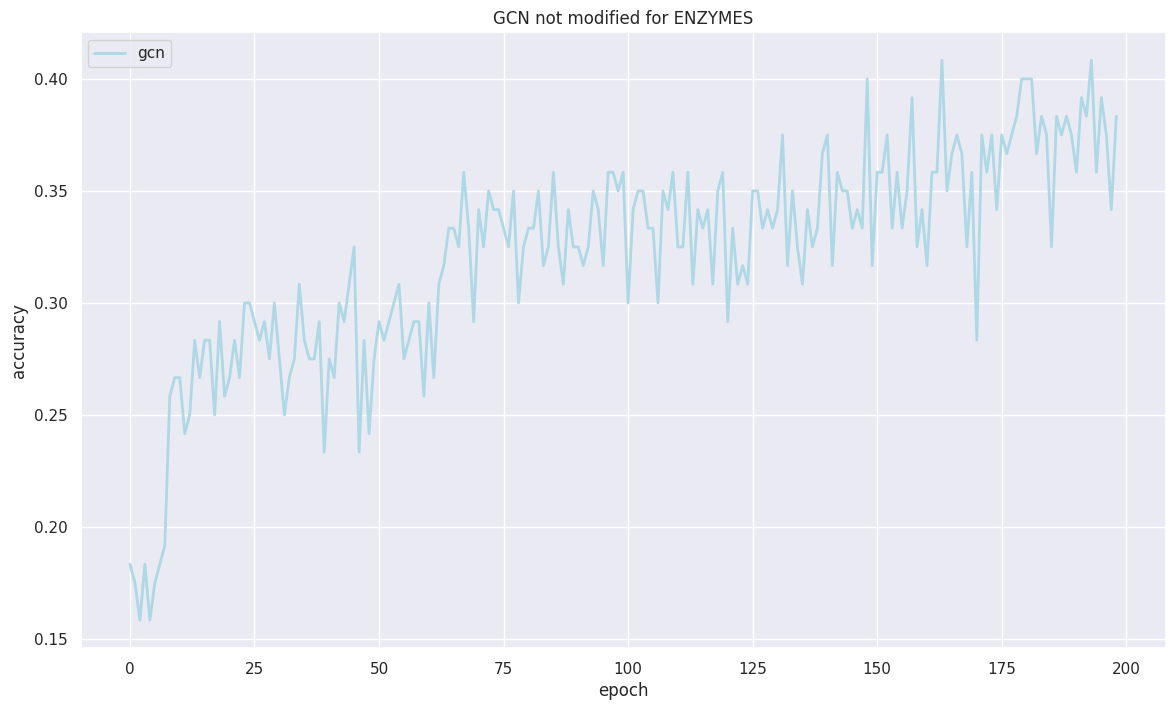

In [77]:
seaborn.set()
plt.figure(figsize=(14, 8))
plt.plot(test_accuracies_1_gcn, color='lightblue',
     linewidth=2, label='gcn')
plt.legend(loc='upper left')
plt.title('GCN not modified for ENZYMES')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()